# 0. Load functions and set parameters

In [1]:
# %matplotlib notebook

import os, h5py, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore

sys.path.append('../')
from visualize_functions import show_images, plot_curve, show_grid_plots, label_violinplot
from analyze_spot_functions import NormalizeData
from fitting_functions import load_curve, load_multiple_curves, detect_peaks, remove_outlier, fit_exp_function, analyze_curves
    
# from analyze_RHEED_spot_functions import show_metrics, Gaussian, generate_parameter_file, show_sound, show_fft_frequency, butter_filter, process_pass_filter
# from analyze_RHEED_intensity_functions import NormalizeData, trim_axes, show_images, show_plots
plt.rcParams.update(mpl.rcParamsDefault)

color_green = (27/255,158/255,119/255)
color_orange = (217/255,95/255,2/255)
color_purple = (117/255,112/255,179/255)

rc_plot = {'figure.figsize':(12,2.5),
          'axes.facecolor':'white',
          'axes.grid': False,
          'axes.titlesize': 18,
          'axes.labelsize': 18,

          'xtick.labelsize': 14,
          'xtick.direction': 'in',
          'xtick.top': True,
          'xtick.bottom': True,
          'xtick.labelbottom': True,
          'xtick.labeltop': False,
          
          'ytick.labelsize': 14,
          'ytick.direction': 'in',
          'ytick.right': True,
          'ytick.left': True,
          'ytick.labelleft': True,
          'ytick.labelright': False,

          'legend.fontsize': 10,
          'font.family': 'sans-serif'}

rc_img = {'figure.figsize':(8,8),
          'axes.facecolor':'white',
          'axes.grid': False,
          'axes.titlesize': 18,
          'axes.labelsize': 14,
          
          'xtick.labelsize': 12,
          'xtick.direction': 'in',
          'xtick.top': False,
          'xtick.bottom': False,
          'xtick.labelbottom': False,
          'xtick.labeltop': False,
          
          'ytick.labelsize': 12,
          'ytick.direction': 'in',
          'ytick.right': False,
          'ytick.left': False,
          'ytick.labelleft': False,
          'ytick.labelright': False,

          'legend.fontsize': 8,
          'font.family': 'sans-serif'}

# 1. Visualize the spots from collected data

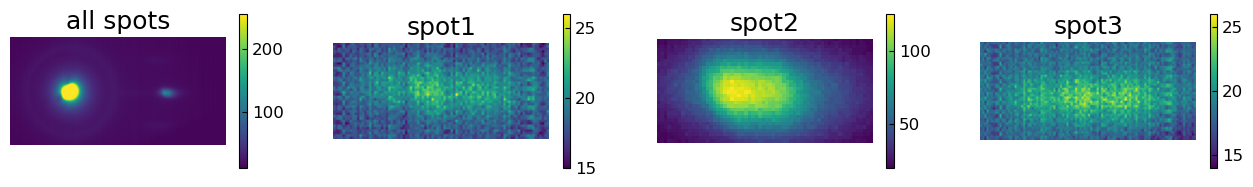

In [2]:
plt.rcParams.update(rc_img)

imgs = []
region = [(45, 85, 360, 450), (140, 170, 408, 470), (220, 265, 355, 455)]
with h5py.File('/scratch/yichen/RHEED_data/STO_STO_test7_06292022.h5', mode='r') as h5:
    spots_name = ['spot1', 'spot2', 'spot3']
    img_all_spots = np.array(h5['growth_2'][20])
    plt.imsave('../figures/1.test7_all_spots.png', img_all_spots)
    
    imgs.append(img_all_spots)
    for i, sn in enumerate(spots_name):
        imgs.append(NormalizeData(img_all_spots[region[i][0]:region[i][1], region[i][2]:region[i][3]]).astype(np.float32))
        plt.imsave('../figures/1.test7_'+sn+'.png', imgs[i+1])

show_images(imgs, ['all spots']+spots_name, img_per_row=4, img_height=0.1, colorbar=True)

# 2. Visualize RHEED intensity oscillation

## 2.1 Treated substrate(step width=0.43±0.04μm)

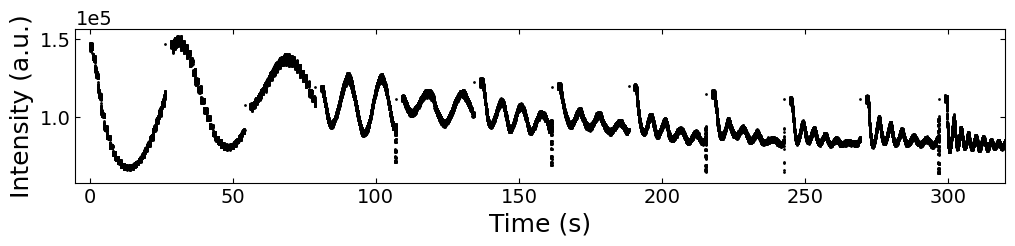

In [3]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, 'growth_6':5, 
               'growth_7':5, 'growth_8':7, 'growth_9':7, 'growth_10':9, 'growth_11':9, 'growth_12':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2), xlim=[-5,320],
           save_path='../figures/3.sample1_intensity.png')

## 2.2 Treated substrate(step width=0.11±0.01μm)

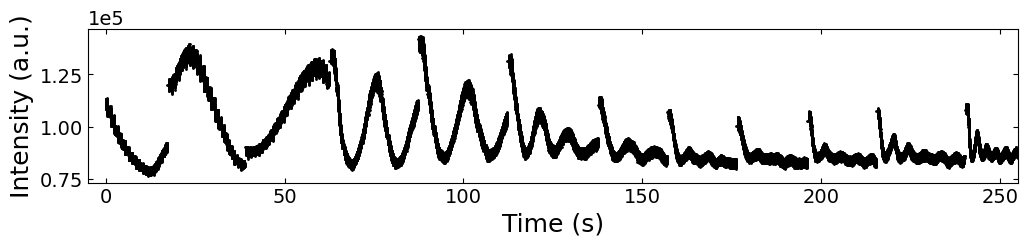

In [4]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, 
               'growth_6':5, 'growth_7':5, 'growth_8':7, 'growth_9':7, 'growth_10':9, 
               'growth_11':9, 'growth_12':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=200)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2), xlim=[-5,255],
           save_path='../figures/3.sample2_intensity.png')           

## 2.3 Untreated substrate(step width=0.28±0.03μm)

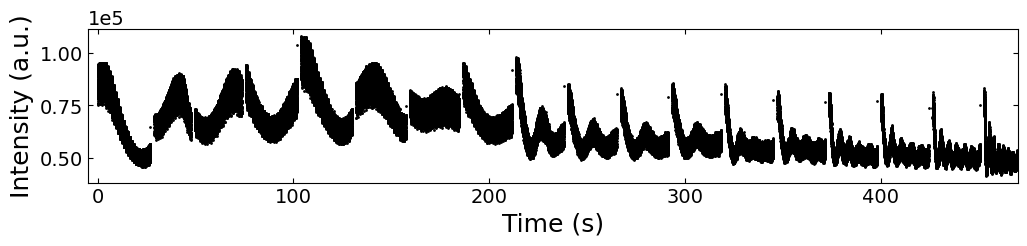

In [5]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test9_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_01':1, 'growth_02':1, 'growth_03':1, 'growth_04':1, 'growth_05':1, 
               'growth_06':1, 'growth_07':1, 'growth_08':1, 'growth_09':3, 'growth_10':3, 
               'growth_11':3, 'growth_12':3, 'growth_13':5, 'growth_14':5, 'growth_15':7, 
               'growth_16':7, 'growth_17':9, 'growth_18':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2), xlim=[-5,470],
           save_path='../figures/3.sample3_intensity.png')           

# 3. Growth mechanism analysis - first unit cell of sample 1

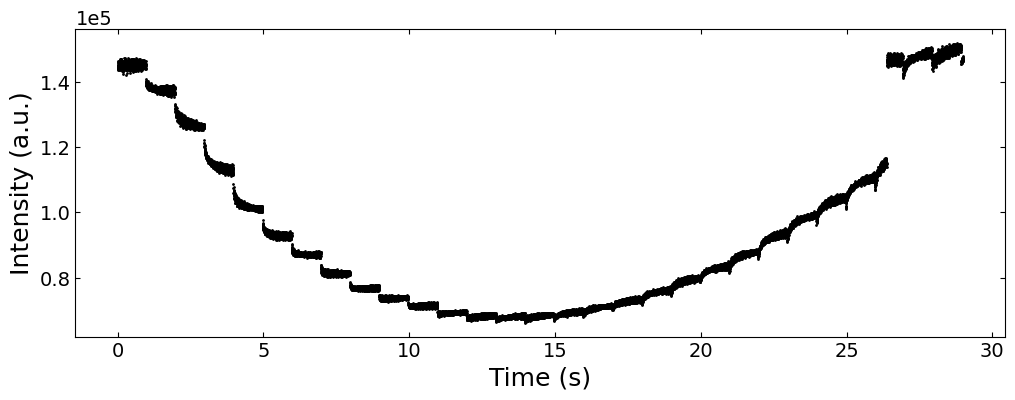

In [6]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
# title = 'Treated substrate(step width=0.43±0.04μm)'
growth_dict = {'growth_1.':1, 'growth_2':1}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=0)
x_sample = x_all[x_all<29]
y_sample = y_all[x_all<29]
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4))

# 4. Analyze the Recovery Curve

## 4.1 Characteristic Time and Intensity Slope:

### Treated substrate (step width=0.43±0.04μm) - growth_1

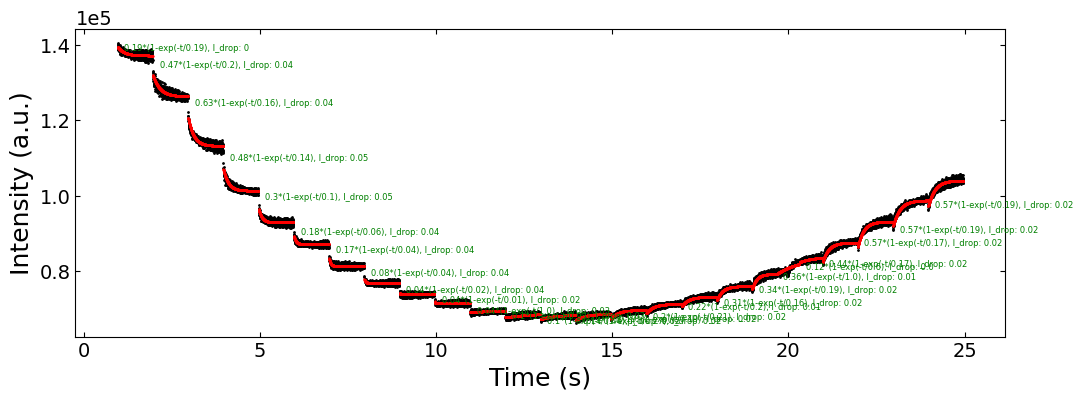

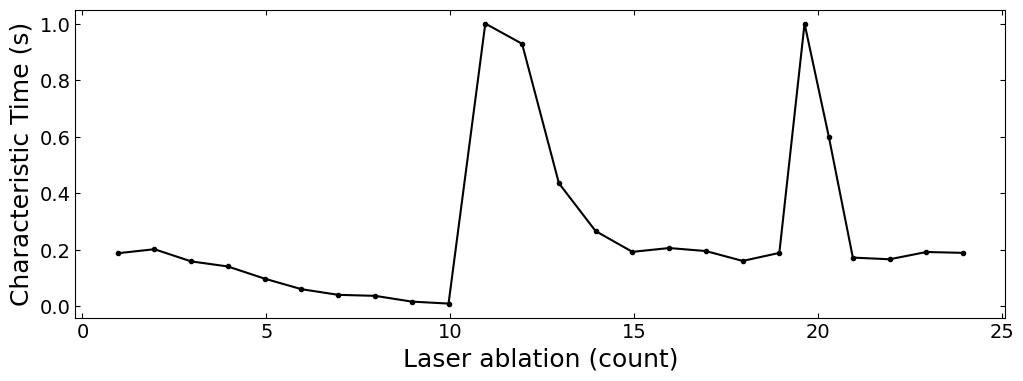

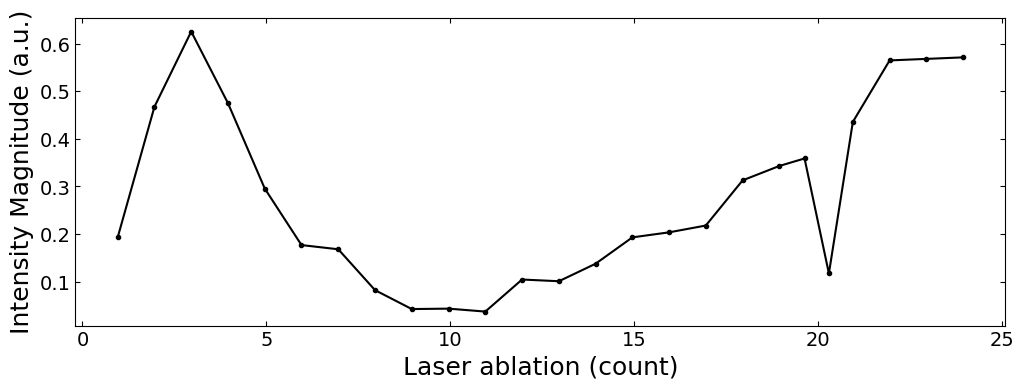

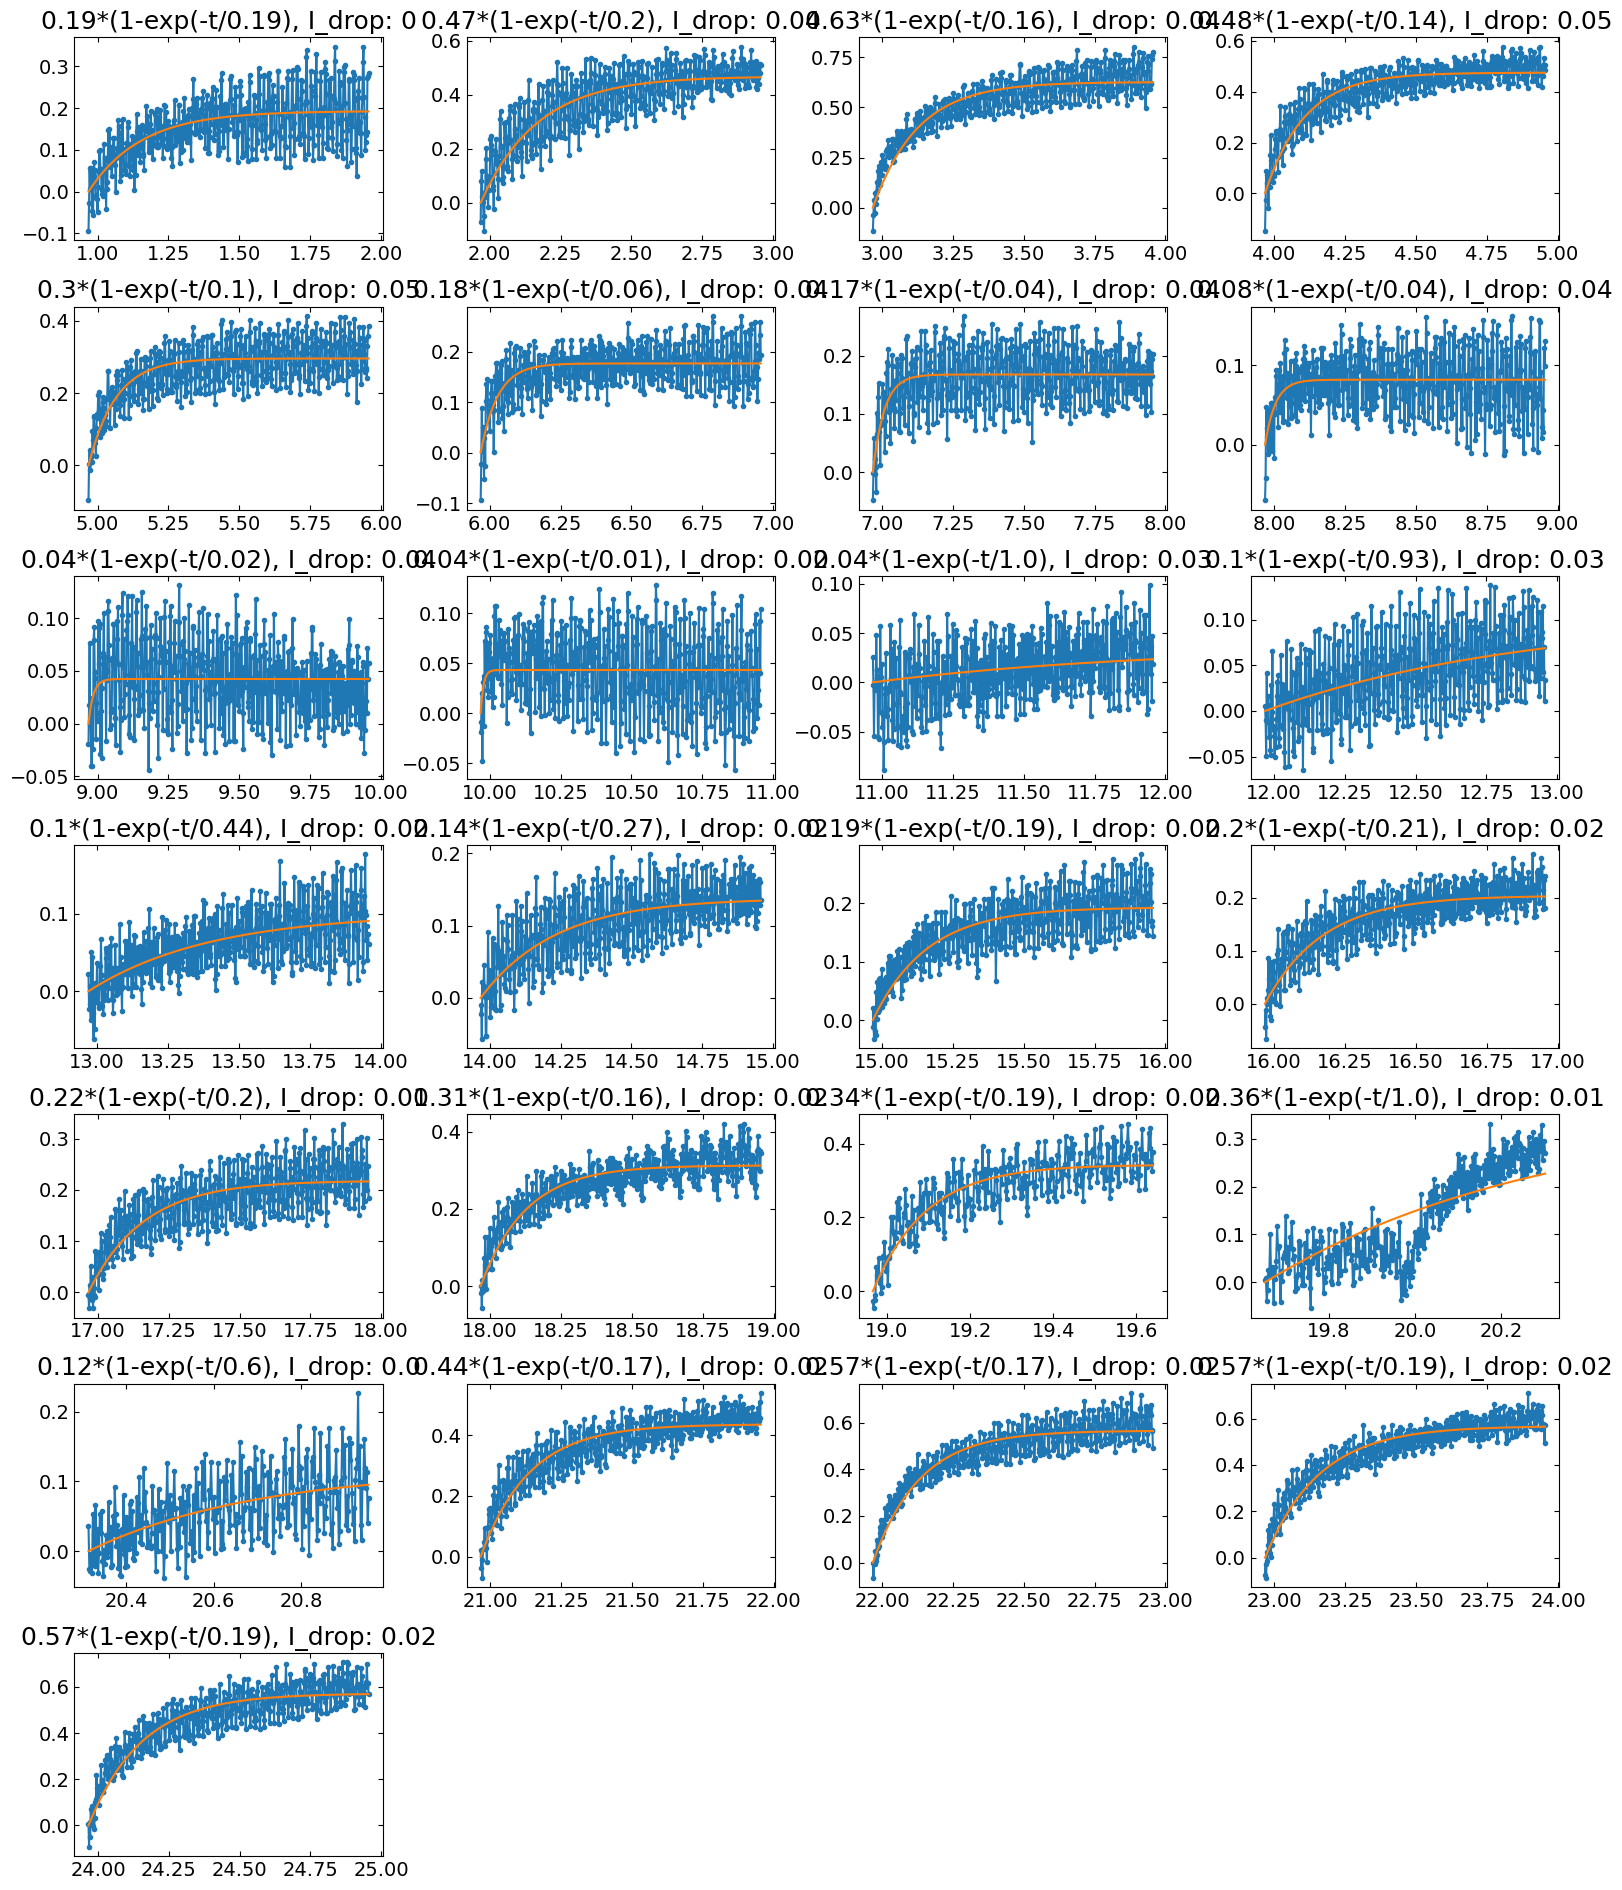

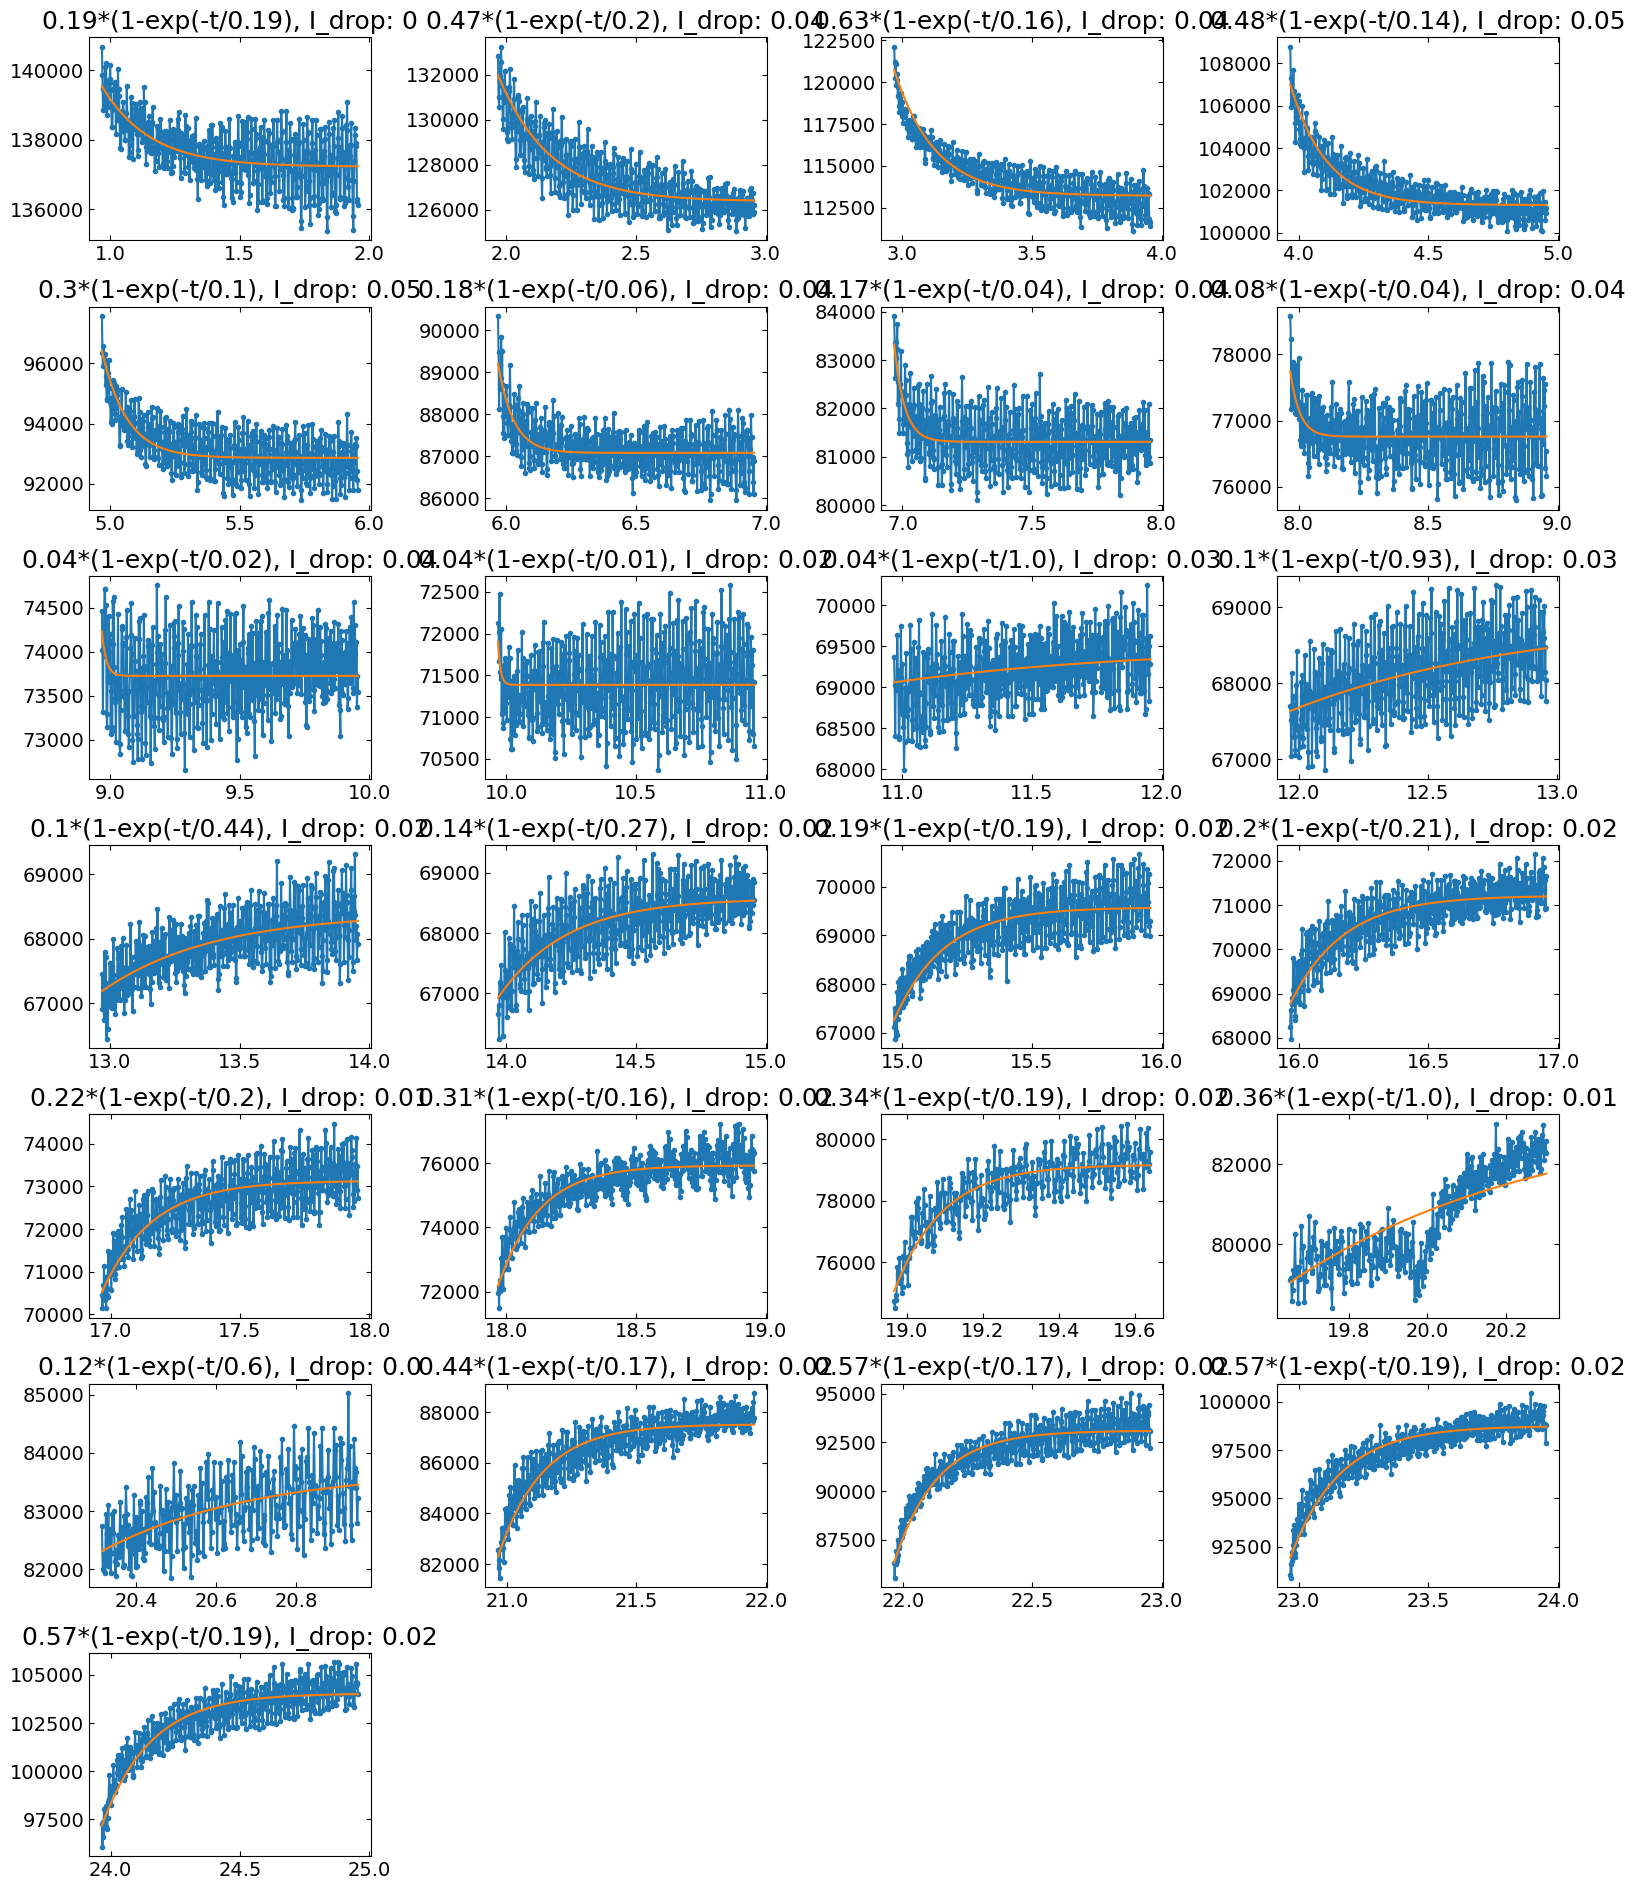

In [7]:
plt.rcParams.update(rc_plot)
growth_dict = {'growth_1.':1}
spot = 'spot_2'
metric = 'img_intensity'
fit_settings={'fit_func': 'exp', 'I_diff': 12000, 'bounds':[0.01, 1], 'p_init':(1, 0.1),
              'from_previous': False, 'weight_previous': False, 'relative_intensity': False, 'use_prev_as_bound': False}

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
a, tau, x, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=500, interval=1000,  visualize=True, 
                                 fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all, I_drop_list_all] = info

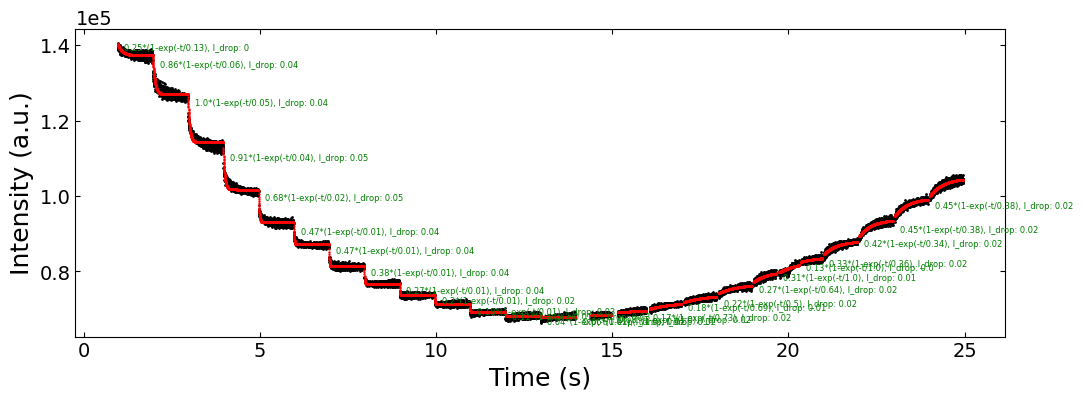

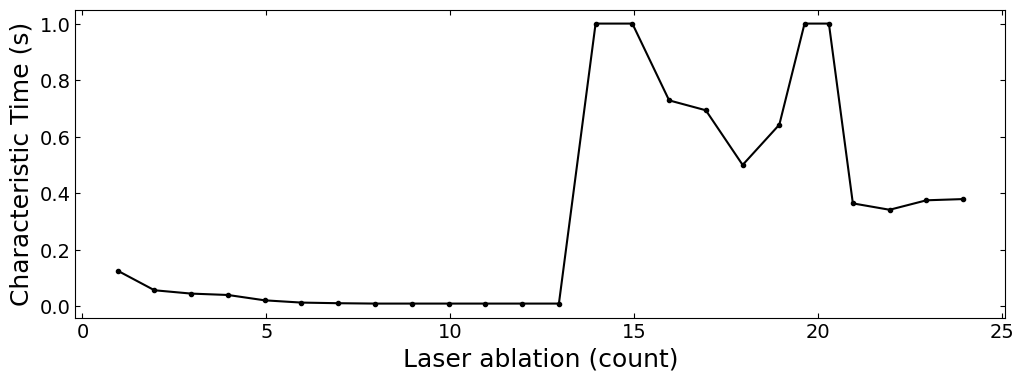

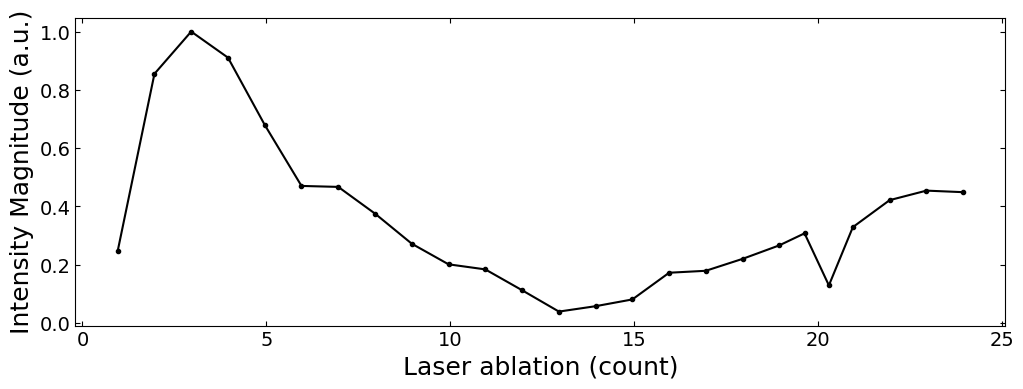

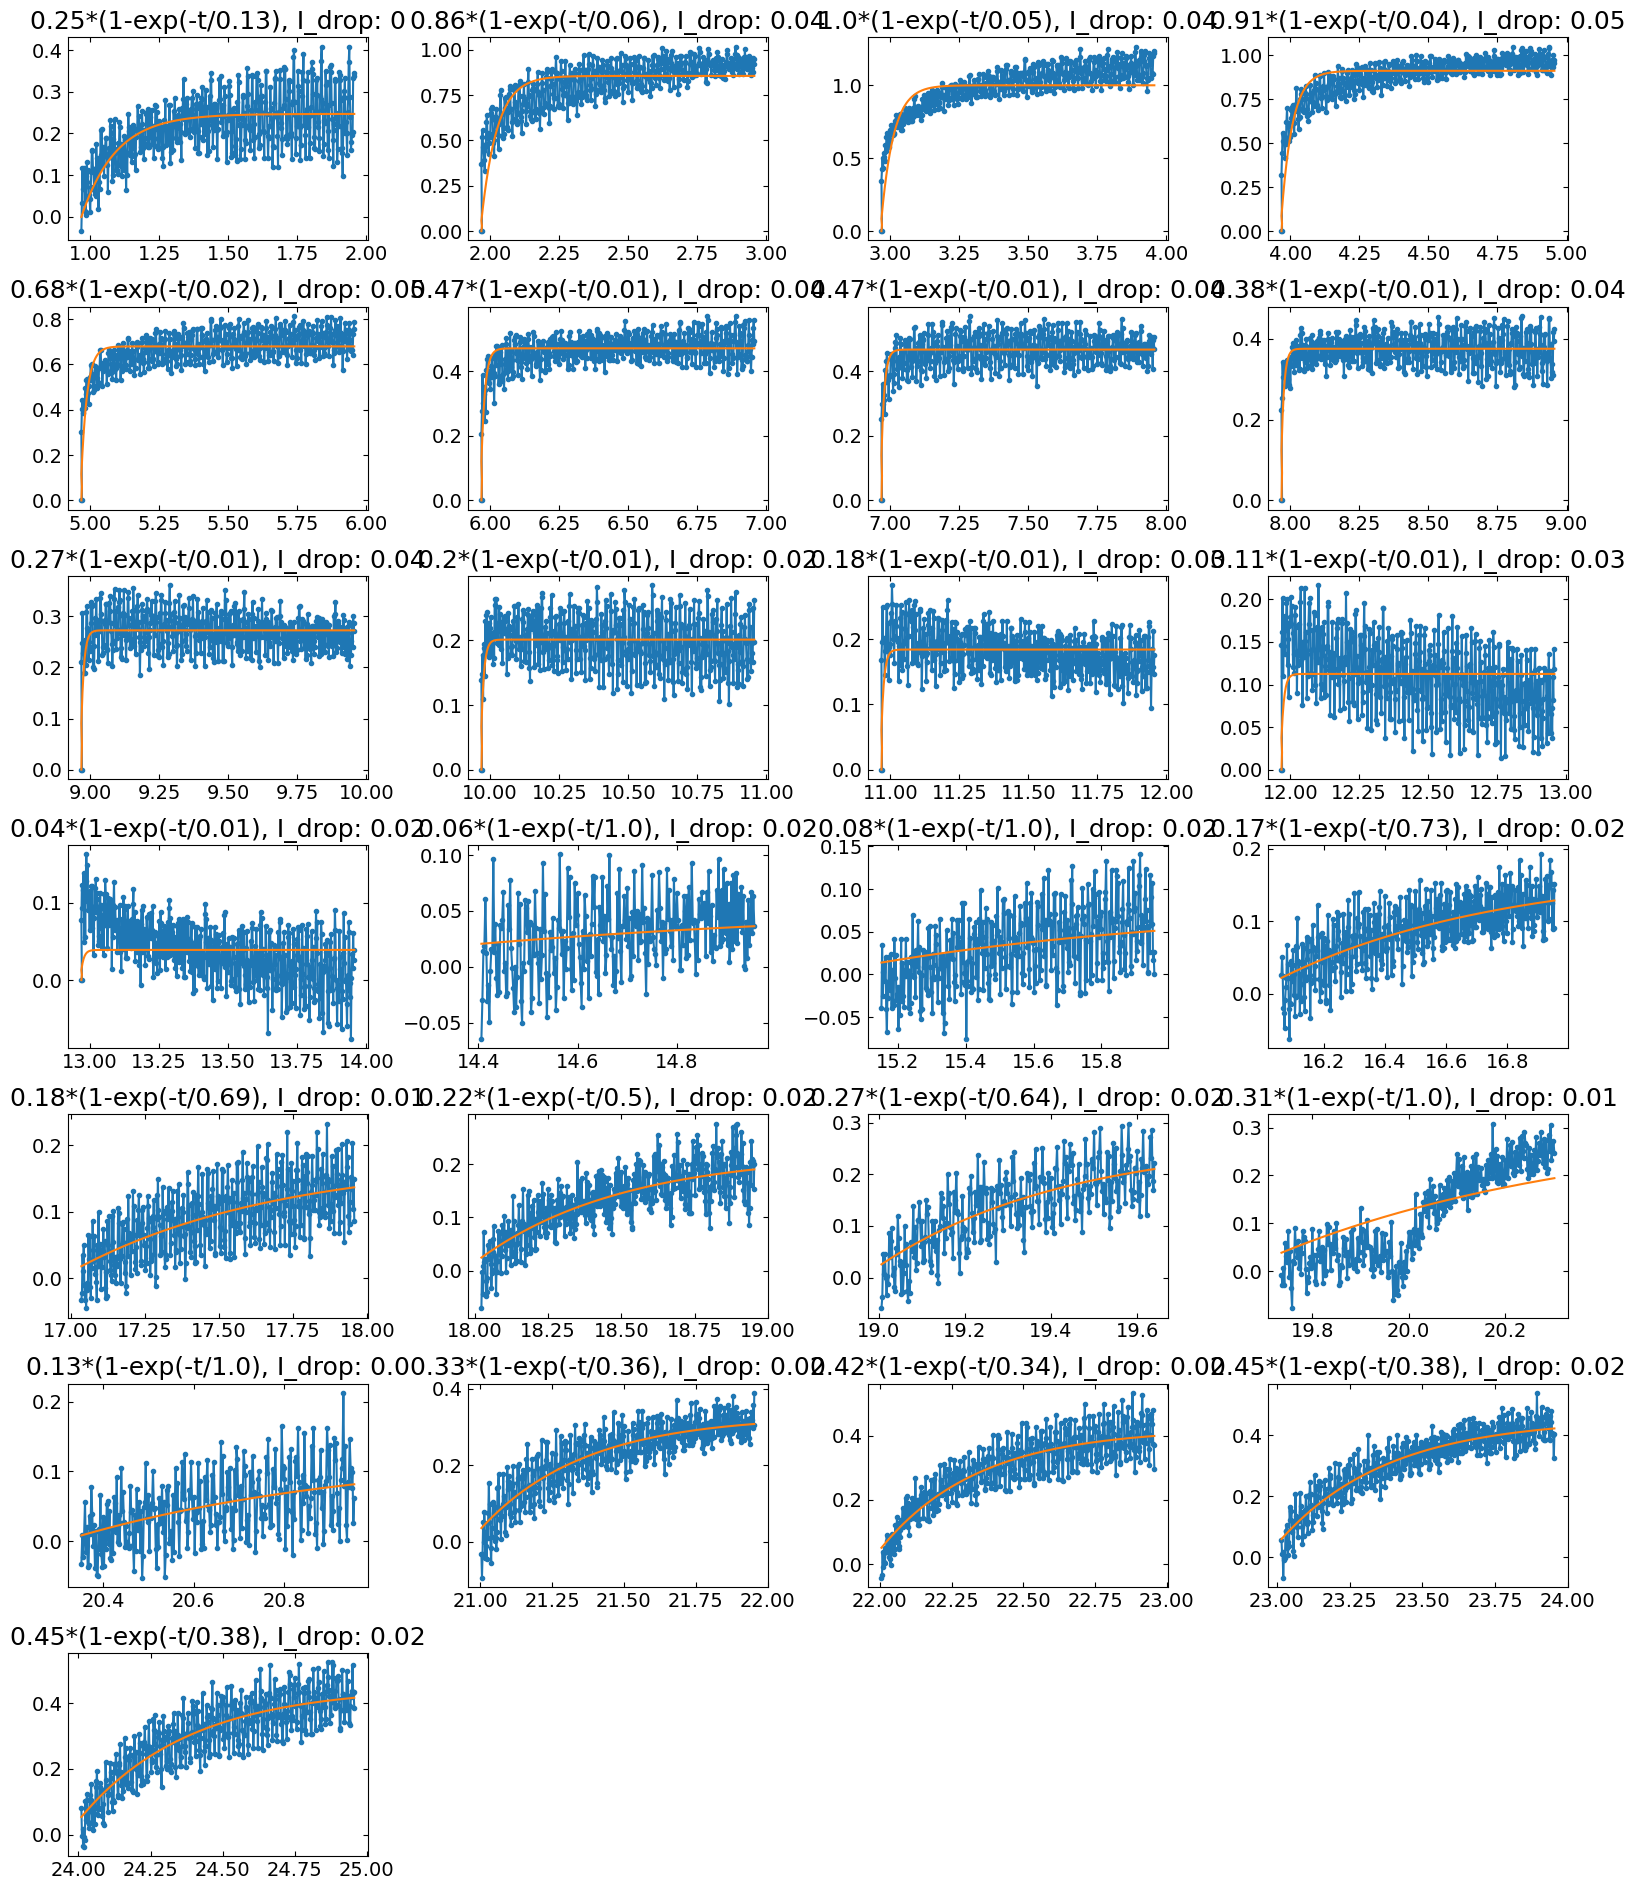

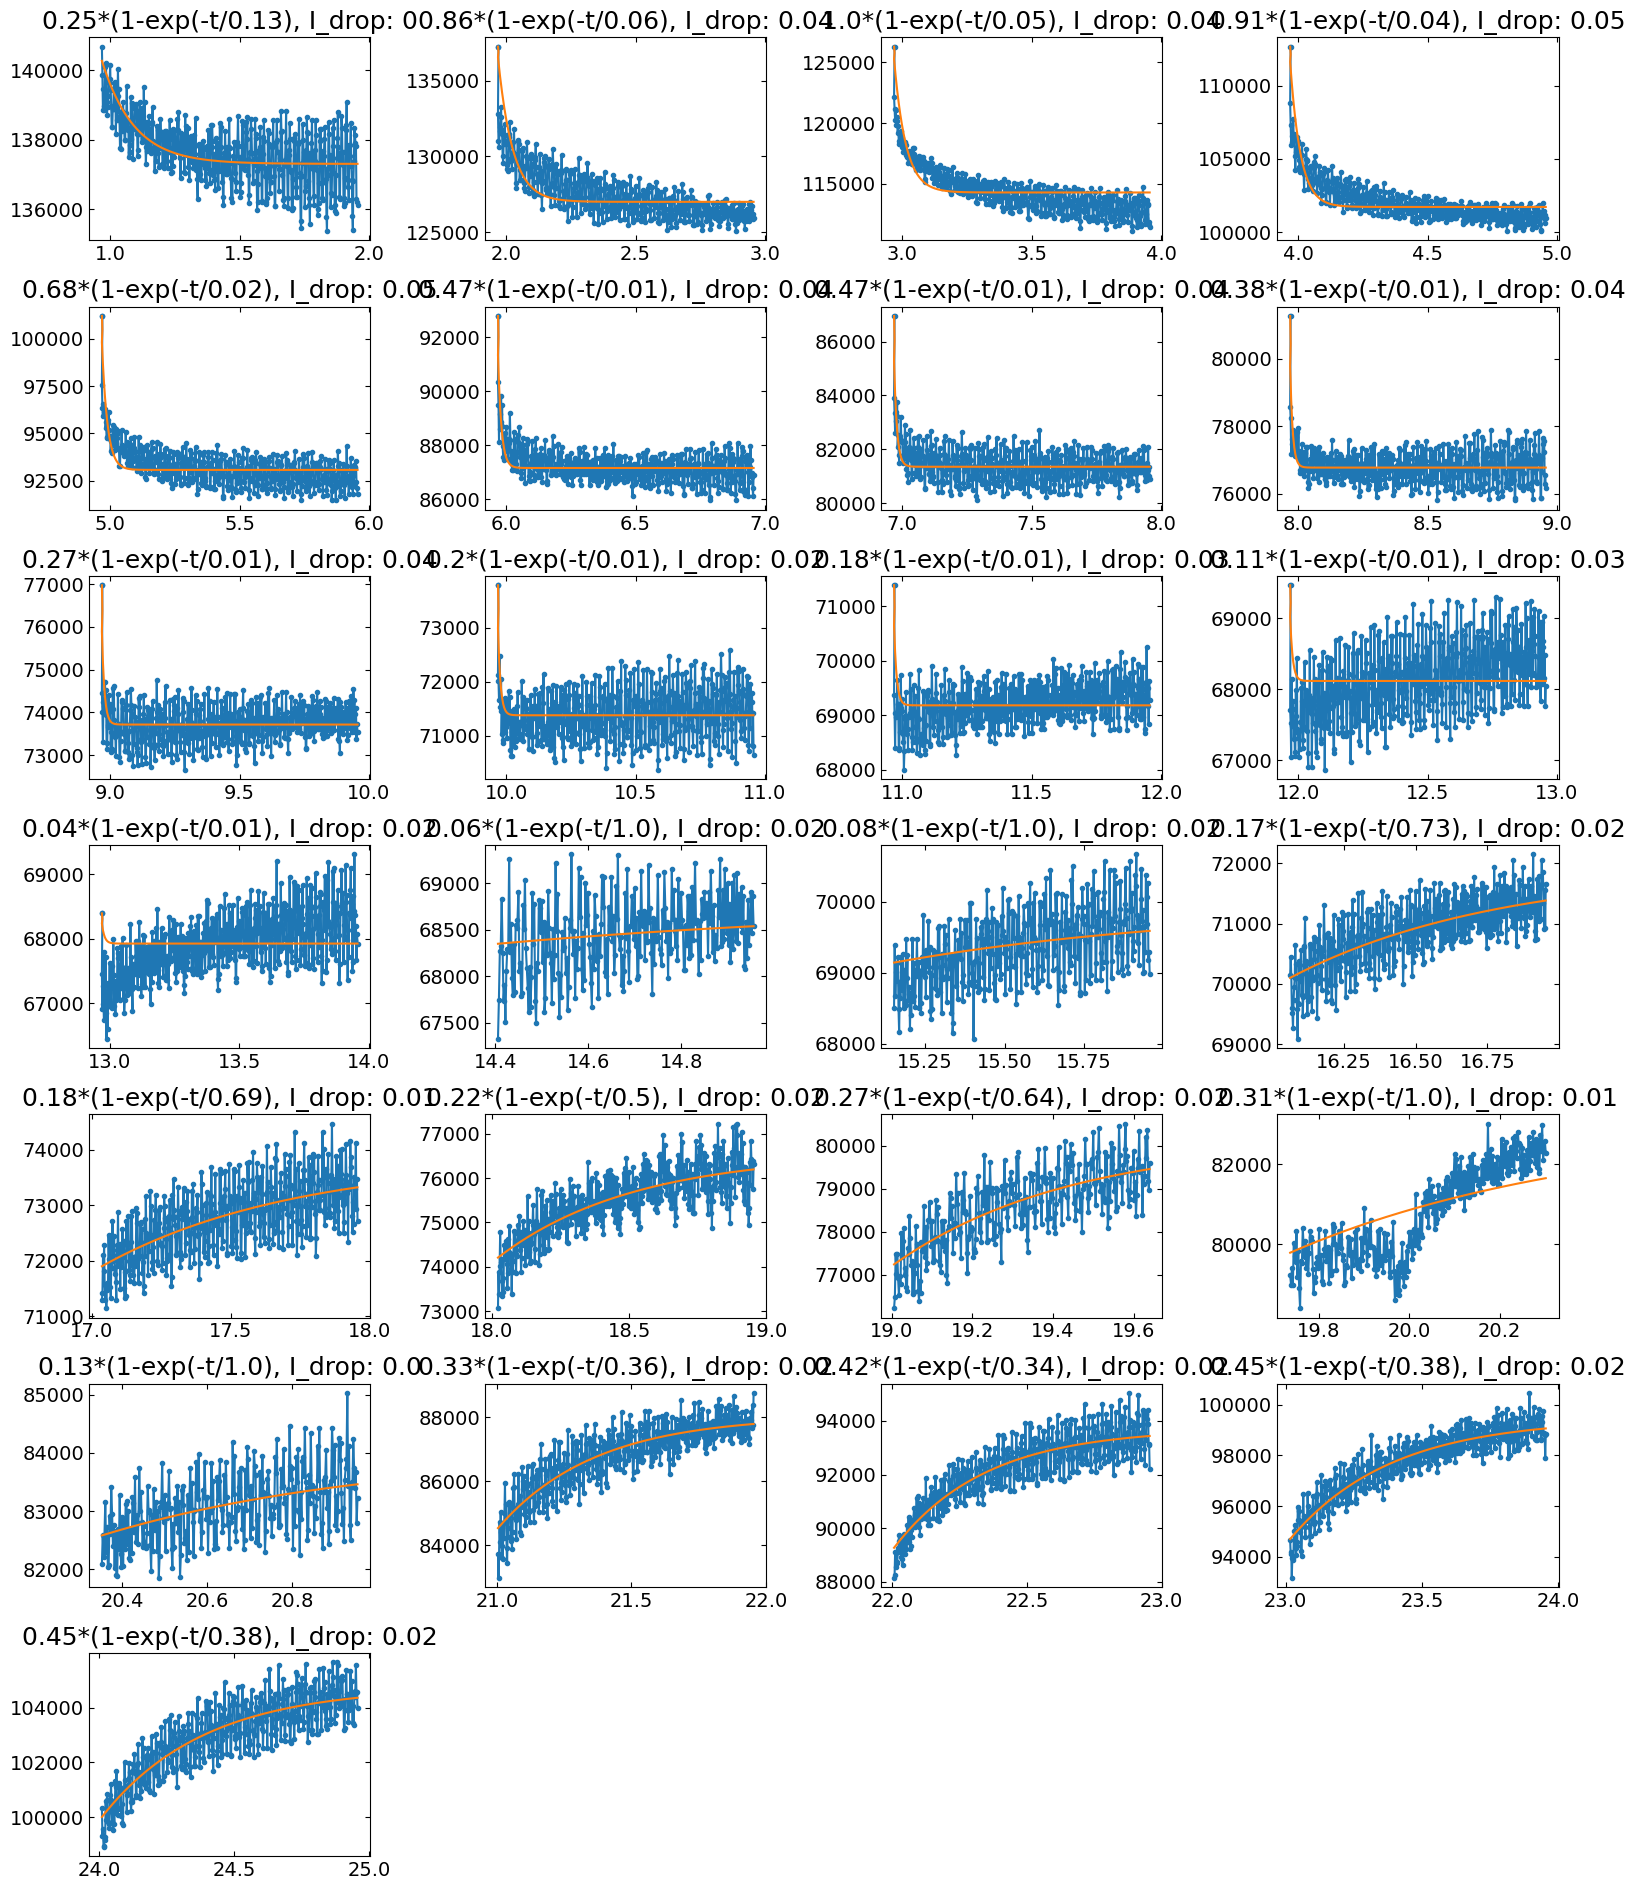

In [8]:
plt.rcParams.update(rc_plot)
growth_dict = {'growth_1.':1}
spot = 'spot_2'
metric = 'img_intensity'
fit_settings={'fit_func': 'exp', 'I_diff': 12000, 'bounds':[0.01, 1], 'p_init':(1, 0.1),
              'from_previous': 2, 'weight_previous': False, 'relative_intensity': False, 'use_prev_as_bound': True}

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
a, tau, x, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=500, interval=1000,  visualize=True, 
                                 fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, labels_all, I_drop_list_all] = info

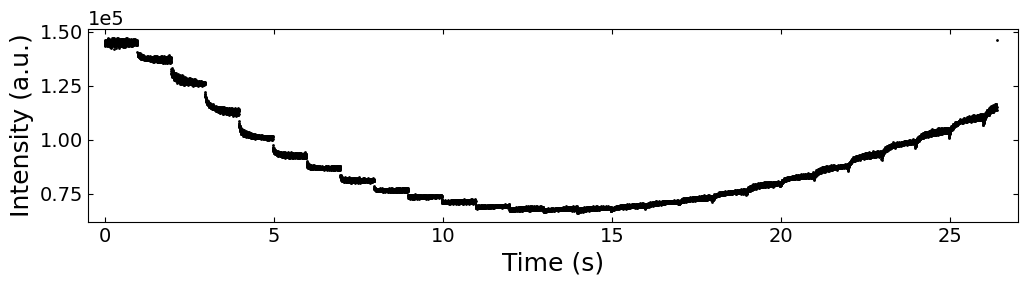

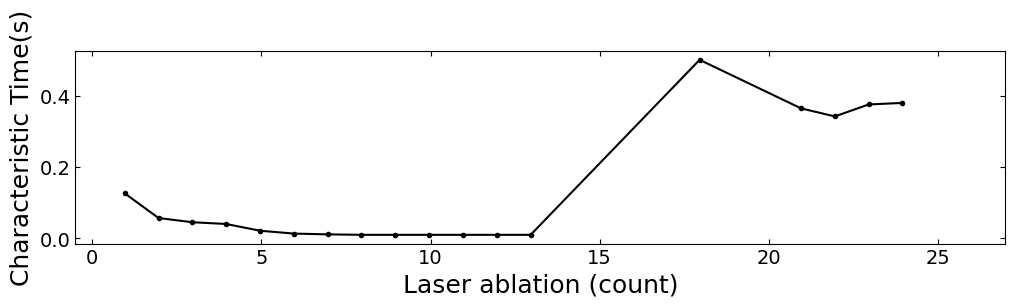

In [9]:
sample_x, sample_y = load_curve(h5_para_file, 'growth_1.', 'spot_2', 'img_intensity', camera_freq=500, x_start=0)
plot_curve(sample_x, sample_y, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5), xlim=(-0.5, 27))
x_clean, tau_clean = remove_outlier(x, tau, 0.8)
plot_curve(x_clean, tau_clean, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time(s)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-0.5,27))

## 4.2 Collect diffusion time constant for three samples

In [10]:
# fit_settings={'fit_func': 'exp', 'I_diff': 8000, 'bounds':[0.01, 1], 'p_init':(1, 0.1),
#               'from_previous': 2, 'weight_previous': 1, 'relative_intensity': False, 'use_prev_as_bound': True}

fit_settings={'fit_func': 'exp', 'I_diff': 12000, 'bounds':[0.01, 1], 'p_init':(1, 0.1),
              'from_previous': False, 'weight_previous': False, 'relative_intensity': False, 'use_prev_as_bound': False}

### 4.2.1 Treated substrate (step width=0.43±0.04μm)

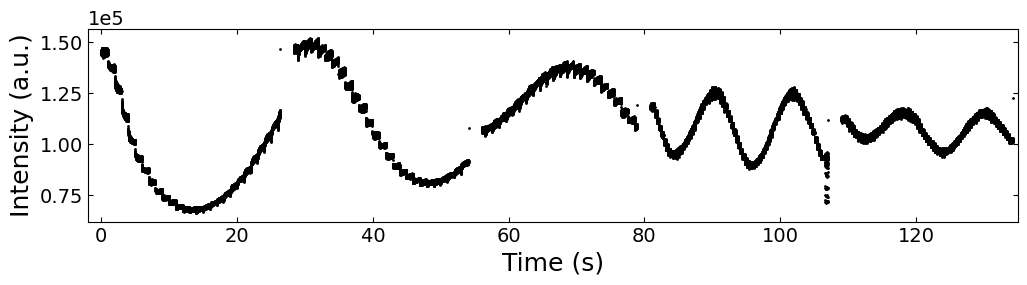

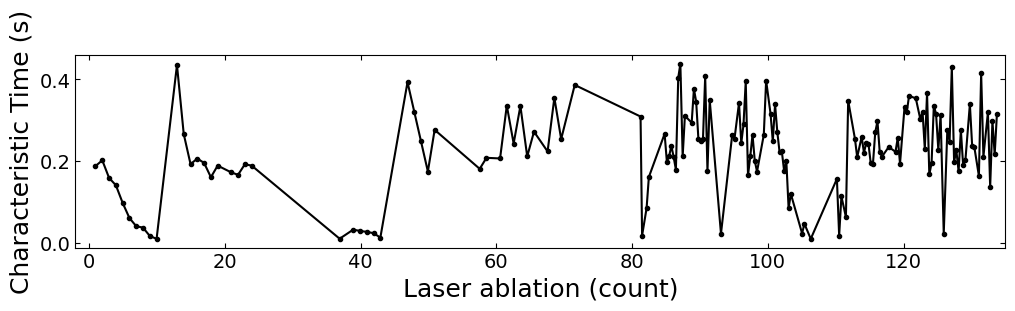

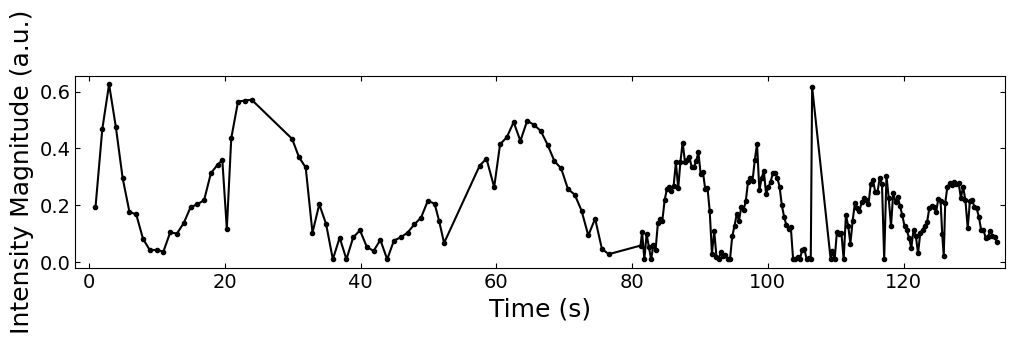

In [11]:
plt.rcParams.update(rc_plot)
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
spot = 'spot_2'
metric = 'img_intensity'

x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
a_sample1, tau_sample1, x_sample1, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=500, 
                                        interval=1000, visualize=False, fit_settings=fit_settings)

plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5), xlim=(-2, 135))

x_sample1_fixed, tau_sample1_fixed = remove_outlier(x_sample1, tau_sample1, 0)
plot_curve(x_sample1_fixed, tau_sample1_fixed, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))
plot_curve(x_sample1, a_sample1, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude (a.u.)', 
           yaxis_style='linear', figsize=(12, 2.5), xlim=(-2, 135))

### 4.2.2 Treated substrate (step width=0.11±0.01μm)

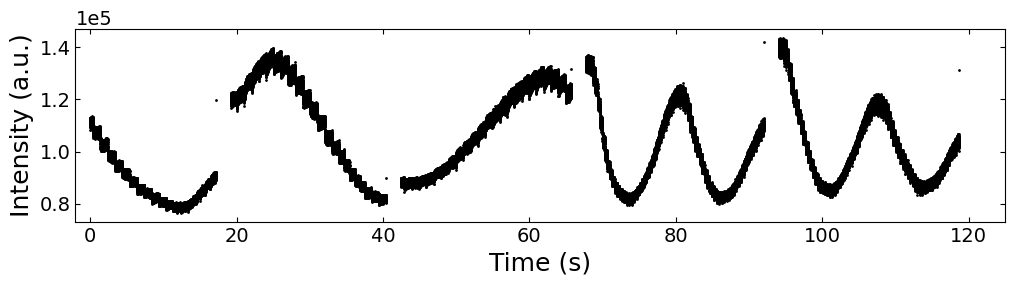

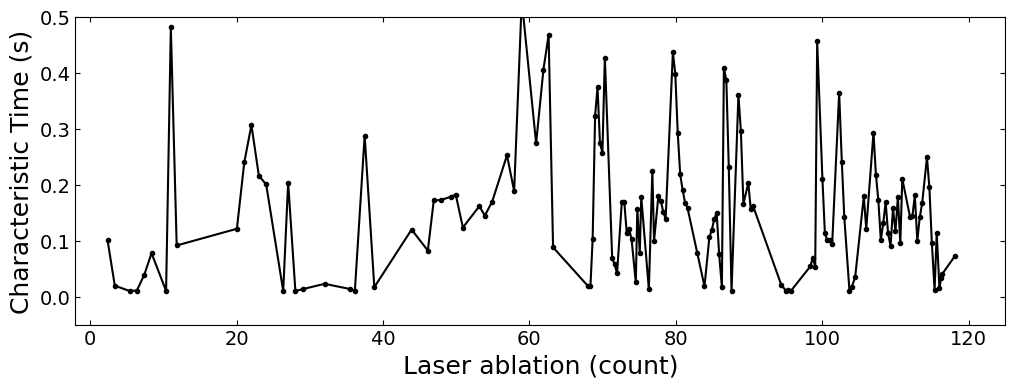

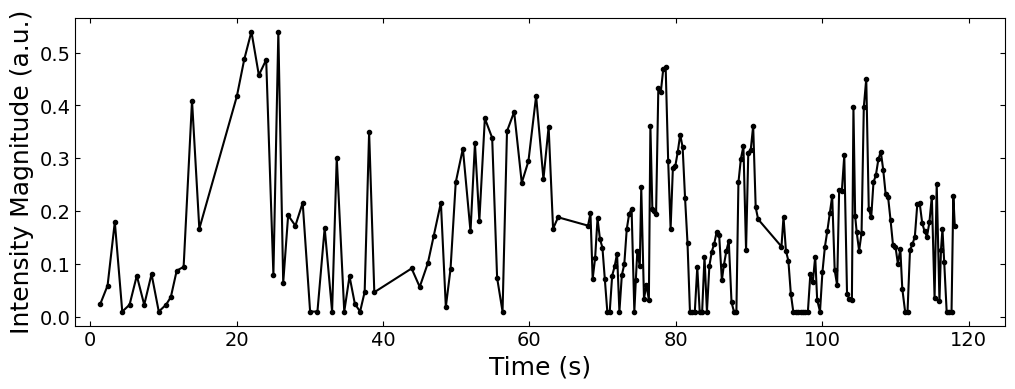

In [12]:
plt.rcParams.update(rc_plot)
h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5), xlim=(-2, 125))

a_sample2, tau_sample2, x_sample2, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=500, 
                                        interval=1000, visualize=False, fit_settings=fit_settings)

x_sample2_fixed, tau_sample2_fixed = remove_outlier(x_sample2, tau_sample2, 0.4)
plot_curve(x_sample2_fixed, tau_sample2_fixed, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 4), xlim=(-2, 125), ylim=(-0.05, 0.5))

plot_curve(x_sample2, a_sample2, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude (a.u.)', 
           yaxis_style='linear', figsize=(12, 4), xlim=(-2, 125))

### 4.2.3 Untreated substrate (step width=0.28±0.03μm)

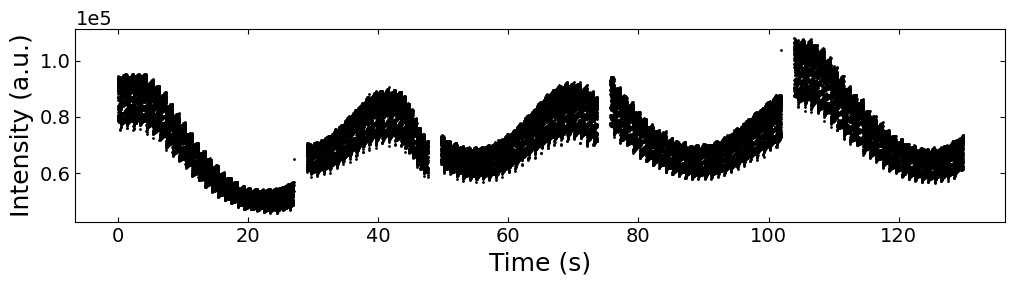

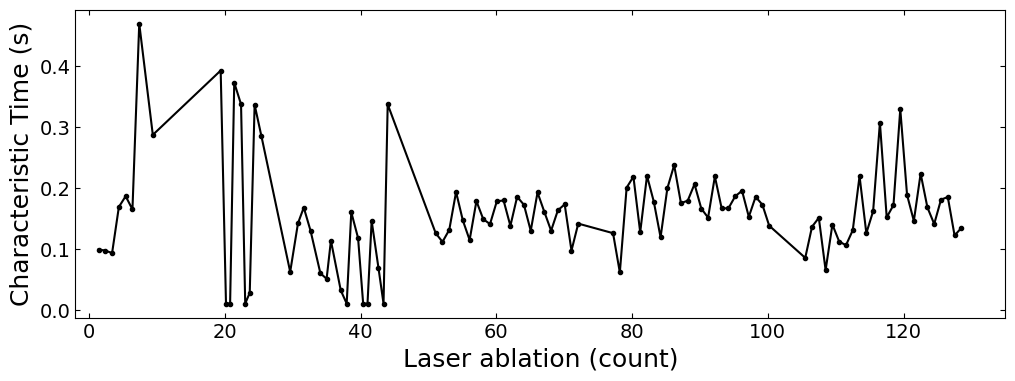

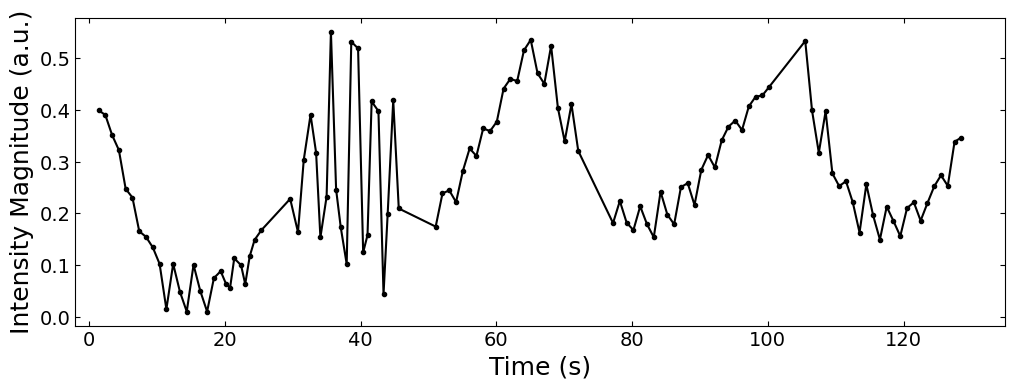

In [13]:
plt.rcParams.update(rc_plot)
h5_para_file = '../../data/test9_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_01':1, 'growth_02':1, 'growth_03':1, 'growth_04':1, 'growth_05':1}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5))

a_sample3, tau_sample3, x_sample3, info = analyze_curves(h5_para_file, growth_dict, spot, metric, camera_freq=500, 
                                        interval=1000, visualize=False, fit_settings=fit_settings)

x_sample3_fixed, tau_sample3_fixed = remove_outlier(x_sample3, tau_sample3, 0.9)
plot_curve(x_sample3_fixed, tau_sample3_fixed, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', figsize=(12, 4), xlim=(-2, 135))

plot_curve(x_sample3, a_sample3, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude (a.u.)', 
           yaxis_style='linear', figsize=(12, 4), xlim=(-2, 135))

## 4.3 Summary of diffusion time constant

### 4.3.1 Violinplot 

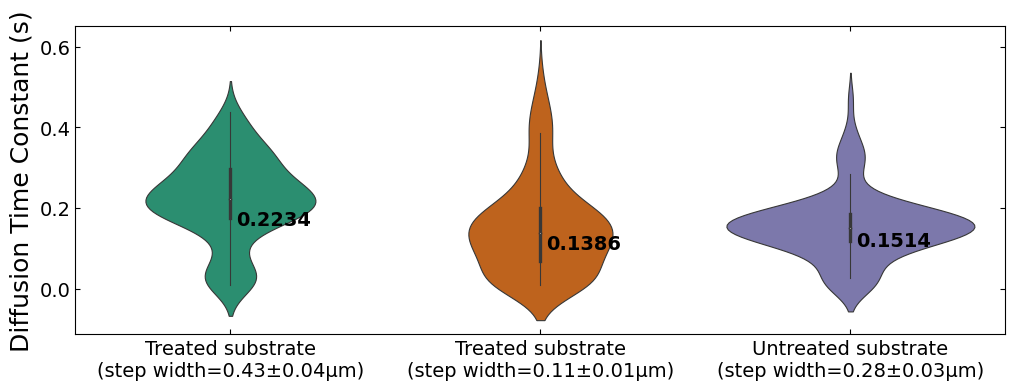

In [14]:
data = [tau_sample1_fixed, tau_sample2_fixed, tau_sample3_fixed]
fig, ax = plt.subplots(figsize=(12,4))

titles = ['Treated substrate\n(step width=0.43±0.04μm)',
          'Treated substrate\n(step width=0.11±0.01μm)',
          'Untreated substrate\n(step width=0.28±0.03μm)']
ax = sns.violinplot(data=data, palette=[color_green, color_orange, color_purple], linewidth=0.8)
ax.set_xticklabels(titles)

label_violinplot(ax, data, label_type='average', text_pos='right')
ax.set_ylabel('Diffusion Time Constant (s)')
plt.savefig('../figures/4.violinplot.svg', bbox_inches='tight', dpi=300)
plt.show()

### 4.3.2 Linear trend

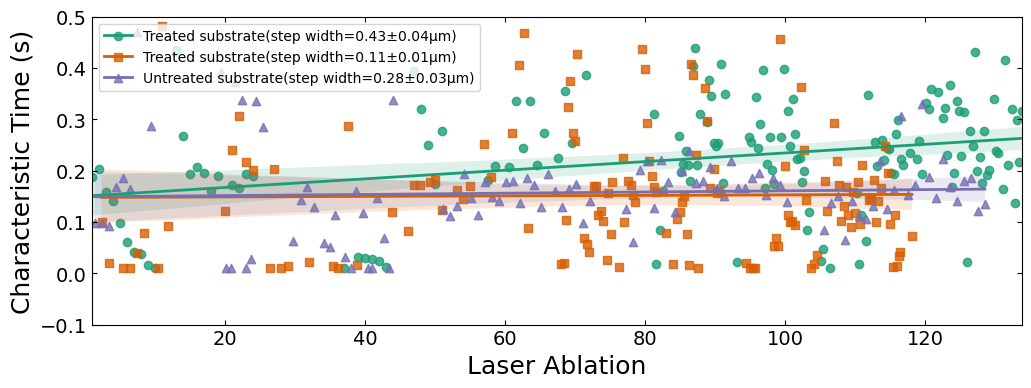

In [15]:
plt.rcParams.update(rc_plot)
titles = ['Treated substrate(step width=0.43±0.04μm)',
          'Treated substrate(step width=0.11±0.01μm)',
          'Untreated substrate(step width=0.28±0.03μm)']

fig, ax = plt.subplots(1, 1, figsize=(12,4))
    
sns.regplot(ax=ax, x=x_sample1_fixed, y=tau_sample1_fixed, label=titles[0], 
            line_kws={'lw': 2, 'label': titles[0]},
            scatter=True, marker='o', color=color_green)
sns.regplot(ax=ax, x=x_sample2_fixed, y=tau_sample2_fixed, label=titles[1],
            line_kws={'lw': 2, 'label': titles[1]},
            scatter=True, marker='s', color=color_orange)
sns.regplot(ax=ax, x=x_sample3_fixed, y=tau_sample3_fixed, label=titles[2],
            line_kws={'lw': 2, 'label': titles[2]},
            scatter=True, marker='^', color=color_purple)
handles, labels = ax.get_legend_handles_labels()

n = 3
plt.legend(handles=[(h1, h2) for h1, h2 in zip(handles[:n], handles[n:])], labels=labels[n:], 
           fontsize=10)

plt.xlabel('Laser Ablation')
plt.ylabel('Characteristic Time (s)')
plt.ylim(-0.1, 0.5)
plt.savefig('../figures/4.linear_trend.svg', bbox_inches='tight', dpi=300)
plt.show()